In [1]:
import tensorflow as tf
import utility.initialize_tf
from custom_models.gamornet_keras_module import *
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from utility.display_prediction_results import *
from utility.plotting_helpers import *

2.5.0
2.5.0


In [2]:
training_data = "califa_s_1.0"
testing_data = "nair_abraham_2010_hdf5"
model_path = f"./saved_models/result_models/c2/augmented"


In [3]:
def create_datagen(subset):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        zoom_range=[0.8, 1.2],
        rotation_range=45,
        fill_mode='wrap',
        #cval = 0
        #validation_split = 0.2
    )
    datagen.fit(subset)
    return datagen

In [4]:
x_dataset, y_dataset, metadata = utility.data_loading.load_hdf5_data(name=training_data)
x_dataset = np.expand_dims(x_dataset, axis=3)
y_dataset = np.expand_dims(y_dataset, axis=1)
input_shape = x_dataset.shape[1:]
print(input_shape)
print(np.unique(y_dataset, return_counts = True))

(79, 100, 100)
(100, 100, 1)
(array([0., 1.], dtype=float32), array([43, 36], dtype=int64))


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [5]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=2021)
print(sss.get_n_splits(x_dataset, y_dataset))

#x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=0.8, random_state=2021)


3


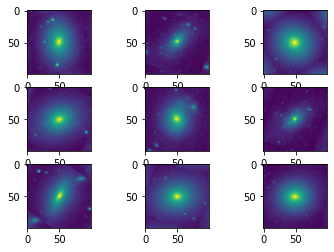

In [6]:
def visualize():
    from matplotlib import pyplot
    # prepare iterator
    datg = create_datagen(x_dataset)
    it = datg.flow(x_dataset, batch_size=1)
    for i in range(9):
        # define subplot
        pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        # plot raw pixel data
        pyplot.imshow(image)
    # show the figure
    pyplot.show()
visualize(); 
#print(y_val)

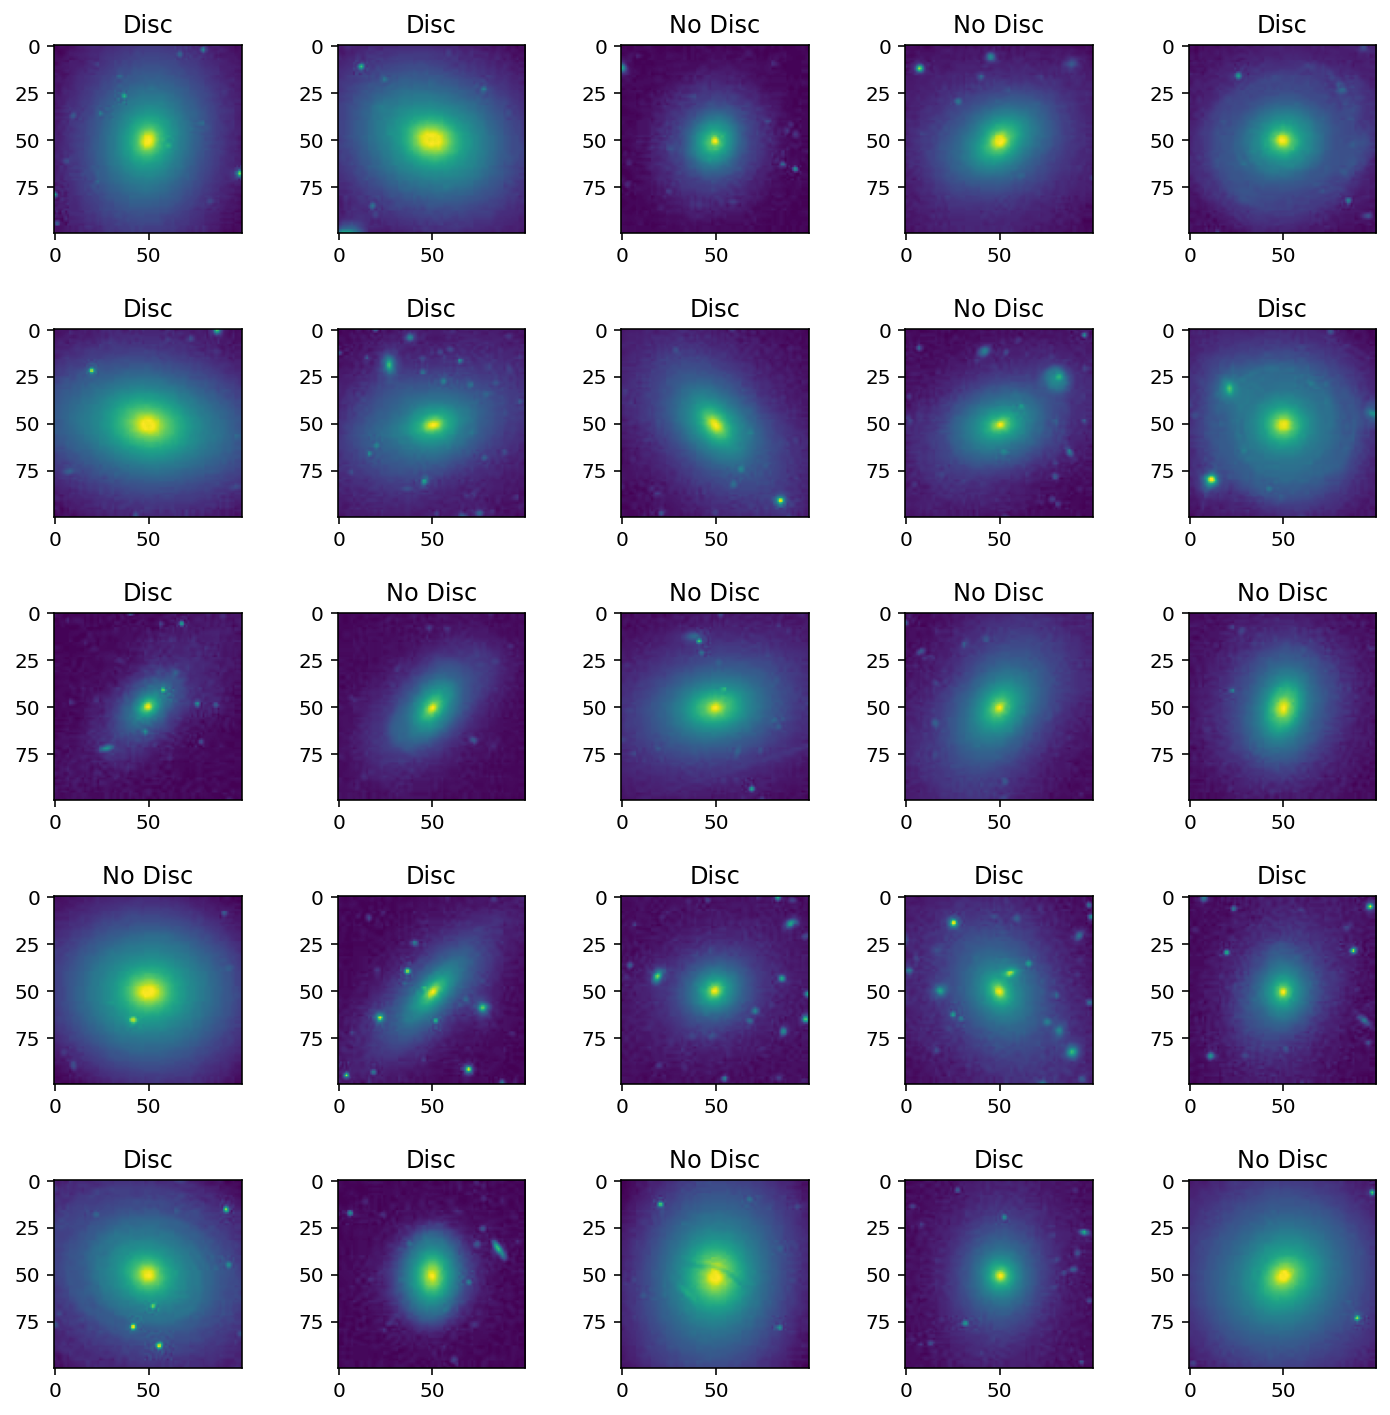

In [7]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 144
plot_classification_results(images=x_dataset, y_preds=y_dataset, y_trues=y_dataset, y_labels=("No Disc", "Disc"), random_sample=True)

In [8]:
import numpy as np

class RAI(tf.keras.initializers.Initializer):

    def __init__(self, fan_in=None, fan_out=None):
        self.fan_in = fan_in
        self.fan_out = fan_out

    def __call__(self, shape, dtype=None, **kwargs):
        """Randomized asymmetric initializer.
        It draws samples using RAI where fan_in is the number of input units in the weight
        tensor and fan_out is the number of output units in the weight tensor.
        """
        if len(shape) < 1:  # Just to avoid errors for constants.
            fan_in = fan_out = 1
        elif len(shape) == 1:
            fan_in = fan_out = shape[0]
        elif len(shape) == 2:
            fan_in = shape[0]
            fan_out = shape[1]
        else:
            # Assuming convolution kernels (2D, 3D, or more).
            # kernel shape: (..., input_depth, depth)
            receptive_field_size = 1
            for dim in shape[:-2]:
                receptive_field_size *= dim
                fan_in = shape[-2] * receptive_field_size
                fan_out = shape[-1] * receptive_field_size

        self.fan_in = int(fan_in)
        self.fan_out = int(fan_out)

        V = np.random.randn(self.fan_out, self.fan_in + 1) * 0.6007 / self.fan_in ** 0.5
        for j in range(self.fan_out):
            k = np.random.randint(0, high=self.fan_in + 1)
            V[j, k] = np.random.beta(2, 1)
            W = V[:, :-1].T
            b = V[:, -1]
        print(W.shape)
        print(b.shape)
        #return W.astype(np.float32), b.astype(np.float32)
        return tf.reshape(b.astype(np.float32), shape=shape)

    def  get_config(self):
        return {"fan_in": self.fan_in, "fan_out": self.fan_out}

In [9]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=1500, restore_best_weights=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', patience=1500, cooldown=10)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                    #kernel_initializer=RAI,
                     activation='relu',
                     input_shape=input_shape),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
                  metrics=['SparseCategoricalAccuracy'])


Epoch 1/2250
1/1 [==============================] - 10s 10s/step - loss: 0.6875 - sparse_categorical_accuracy: 0.6923 - val_loss: 1.0473 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/2250
1/1 [==============================] - 0s 105ms/step - loss: 1.2923 - sparse_categorical_accuracy: 0.5128 - val_loss: 1.8892 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/2250
1/1 [==============================] - 0s 101ms/step - loss: 1.8515 - sparse_categorical_accuracy: 0.4615 - val_loss: 0.7152 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/2250
1/1 [==============================] - 0s 96ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.4615 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/2250
1/1 [==============================] - 0s 96ms/step - loss: 0.6882 - sparse_categorical_accuracy: 0.5641 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/2250
1/1 [==============================] - 0s 98ms/step - loss: 0.6967 - sparse_categorical_ac

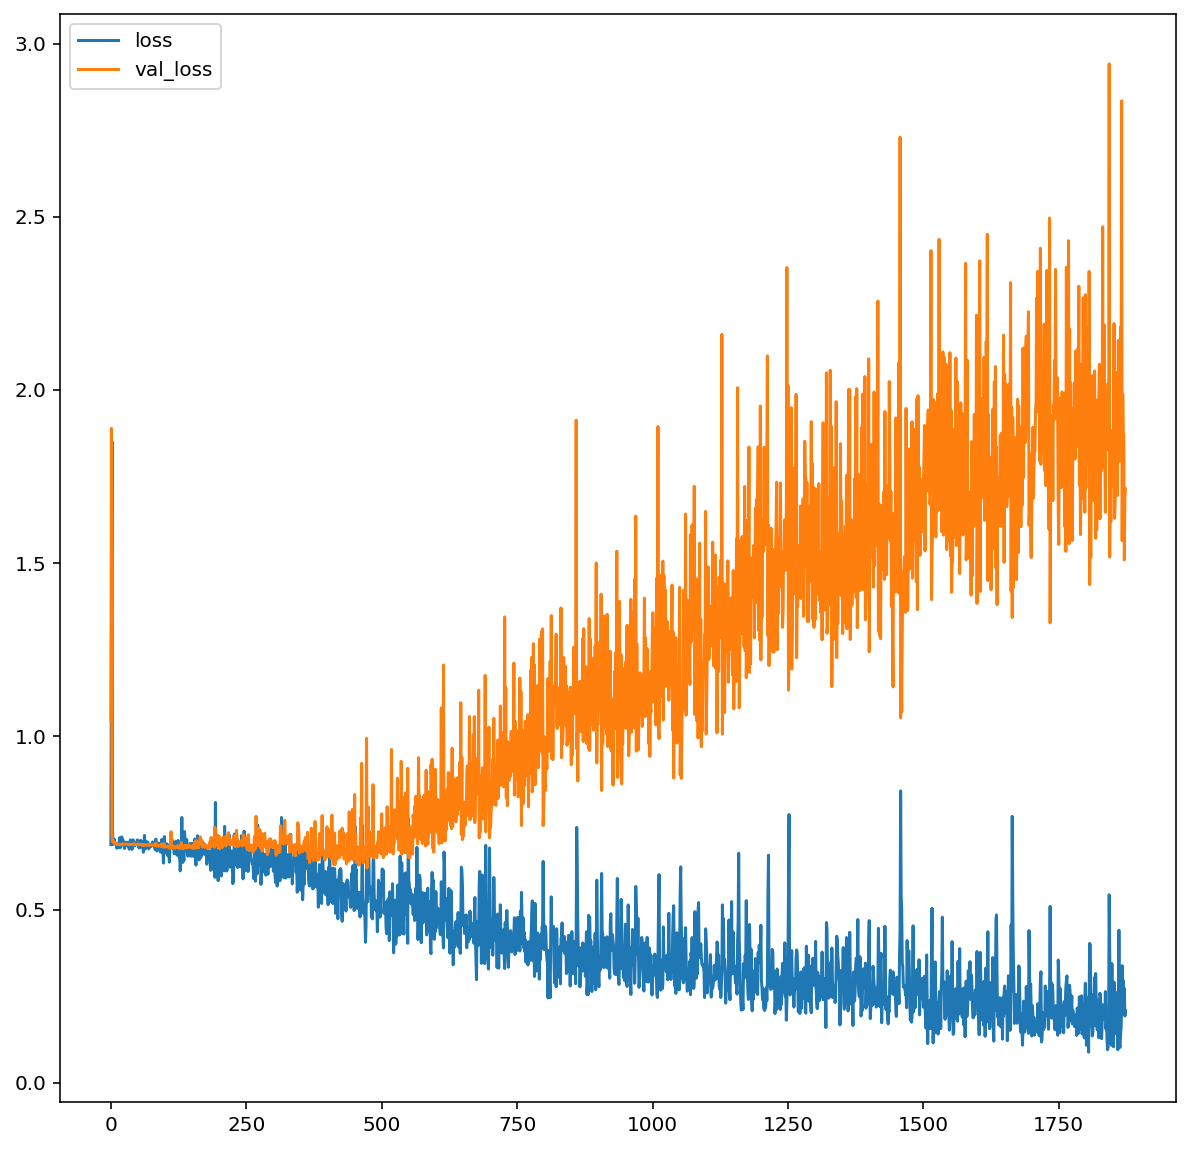

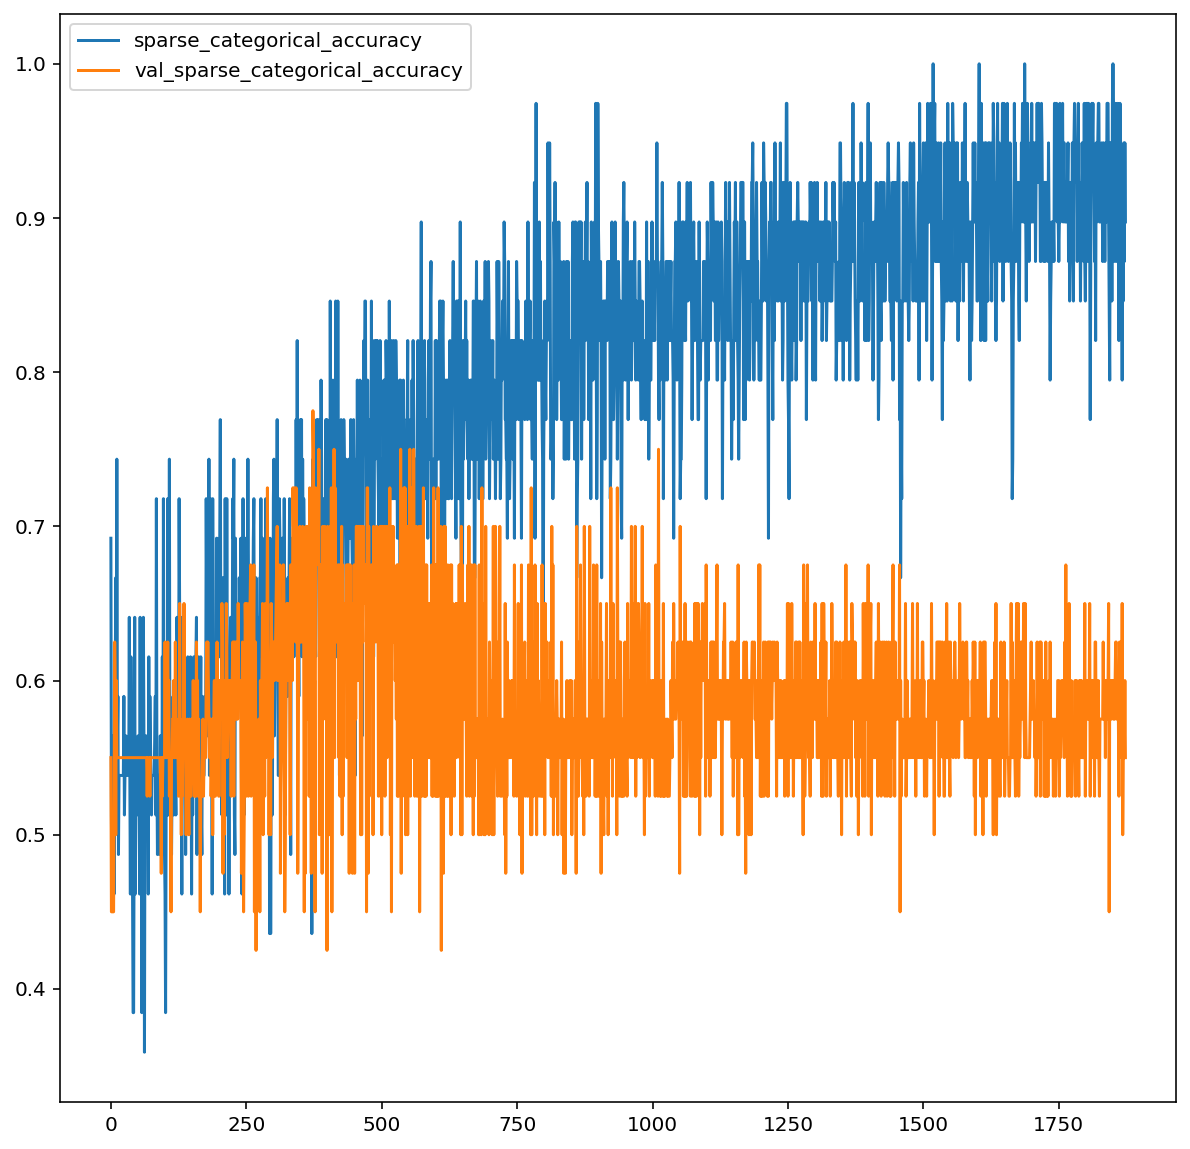

Epoch 1/2250
1/1 [==============================] - 0s 144ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5897 - val_loss: 0.6047 - val_sparse_categorical_accuracy: 0.7250
Epoch 2/2250
1/1 [==============================] - 0s 91ms/step - loss: 0.5944 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.5973 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/2250
1/1 [==============================] - 0s 88ms/step - loss: 0.7026 - sparse_categorical_accuracy: 0.5641 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.7250
Epoch 4/2250
1/1 [==============================] - 0s 92ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.6076 - val_sparse_categorical_accuracy: 0.7500
Epoch 5/2250
1/1 [==============================] - 0s 102ms/step - loss: 0.5577 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.5967 - val_sparse_categorical_accuracy: 0.7250
Epoch 6/2250
1/1 [==============================] - 0s 106ms/step - loss: 0.6864 - sparse_categorical_a

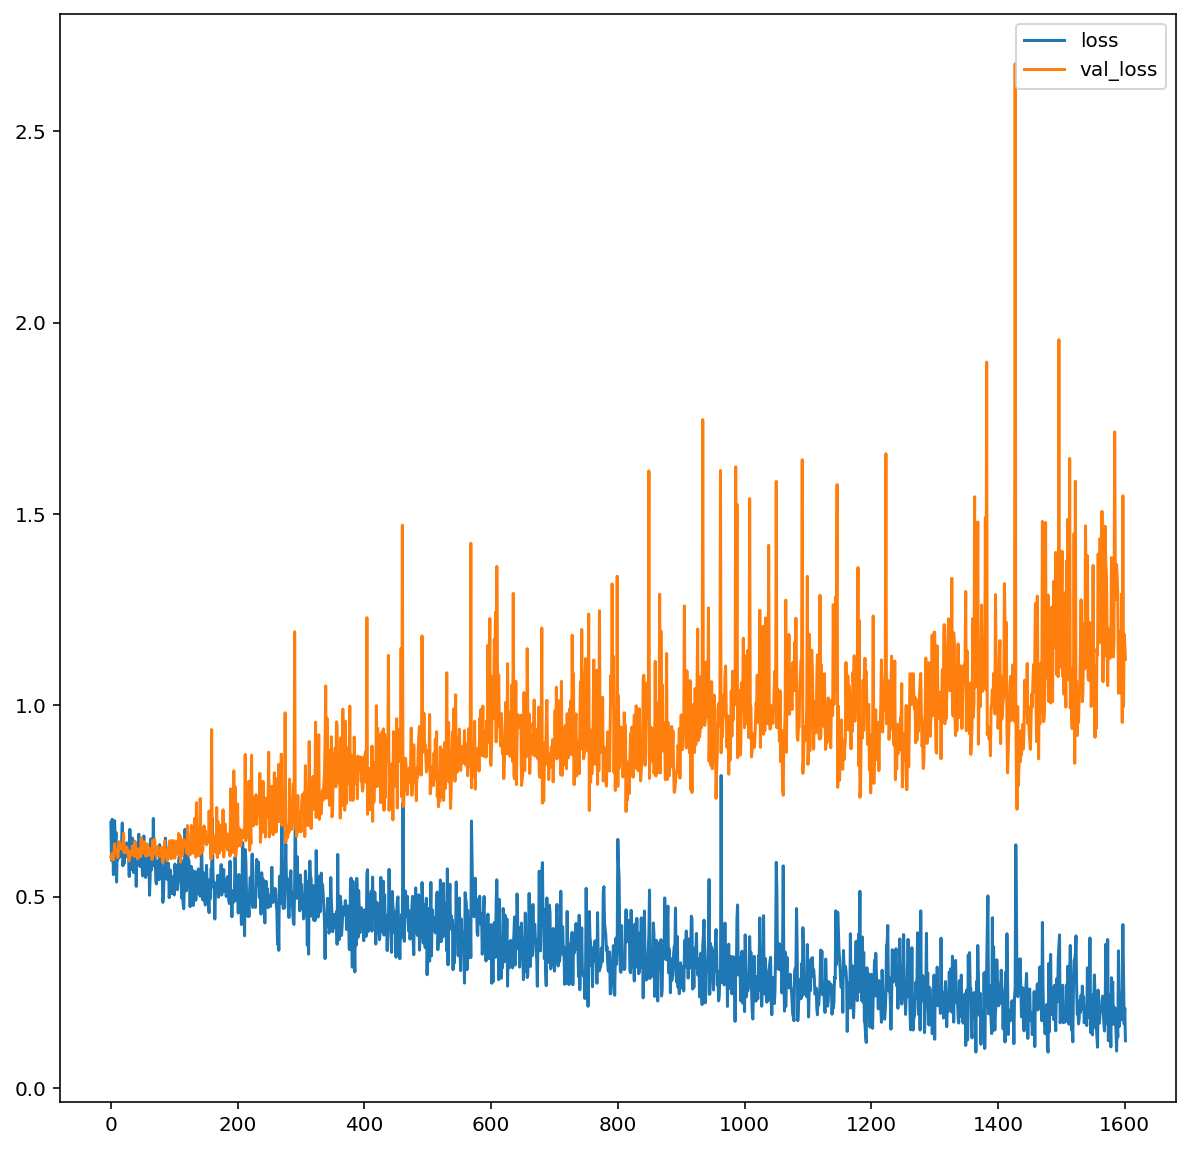

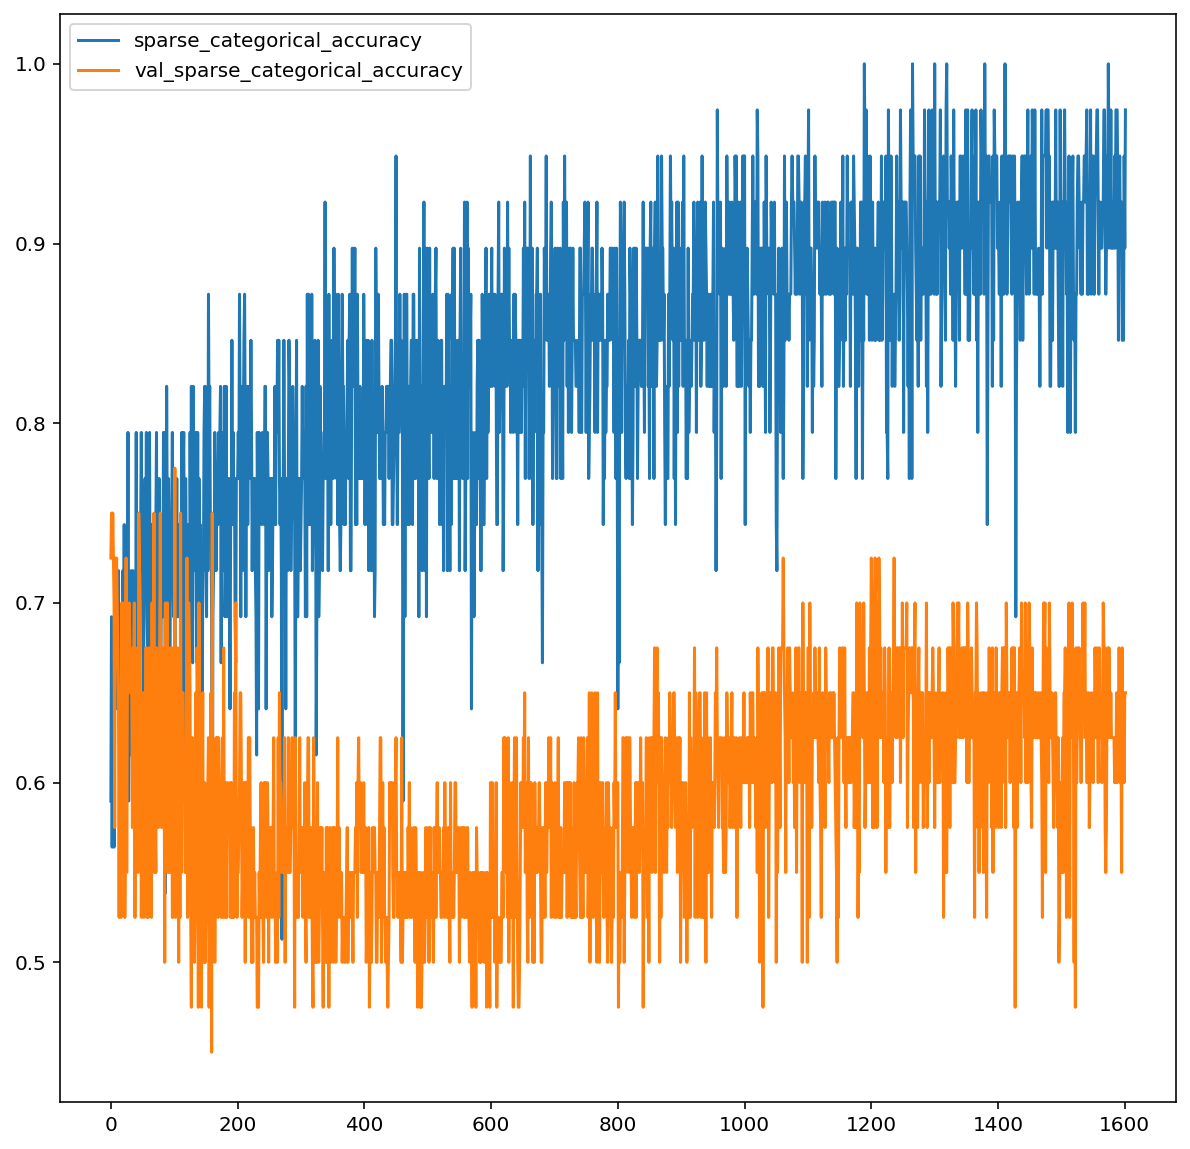

Epoch 1/2250
1/1 [==============================] - 0s 142ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.5786 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/2250
1/1 [==============================] - 0s 97ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.6154 - val_loss: 0.5889 - val_sparse_categorical_accuracy: 0.7000
Epoch 3/2250
1/1 [==============================] - 0s 108ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.5786 - val_sparse_categorical_accuracy: 0.6750
Epoch 4/2250
1/1 [==============================] - 0s 98ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.5664 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/2250
1/1 [==============================] - 0s 103ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.4872 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.6500
Epoch 6/2250
1/1 [==============================] - 0s 99ms/step - loss: 0.5695 - sparse_categorical_a

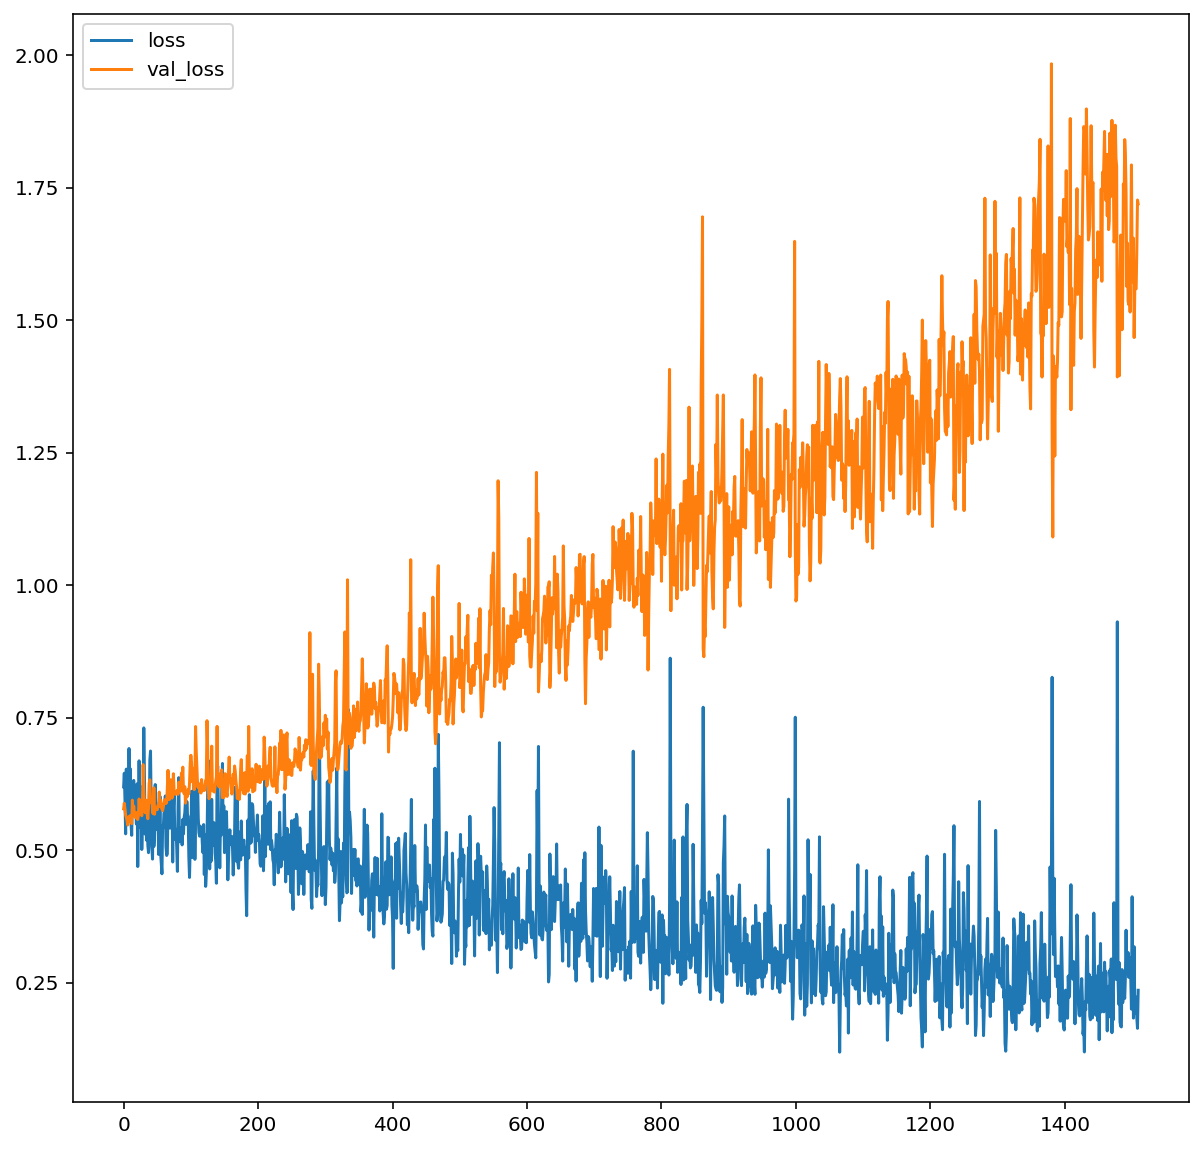

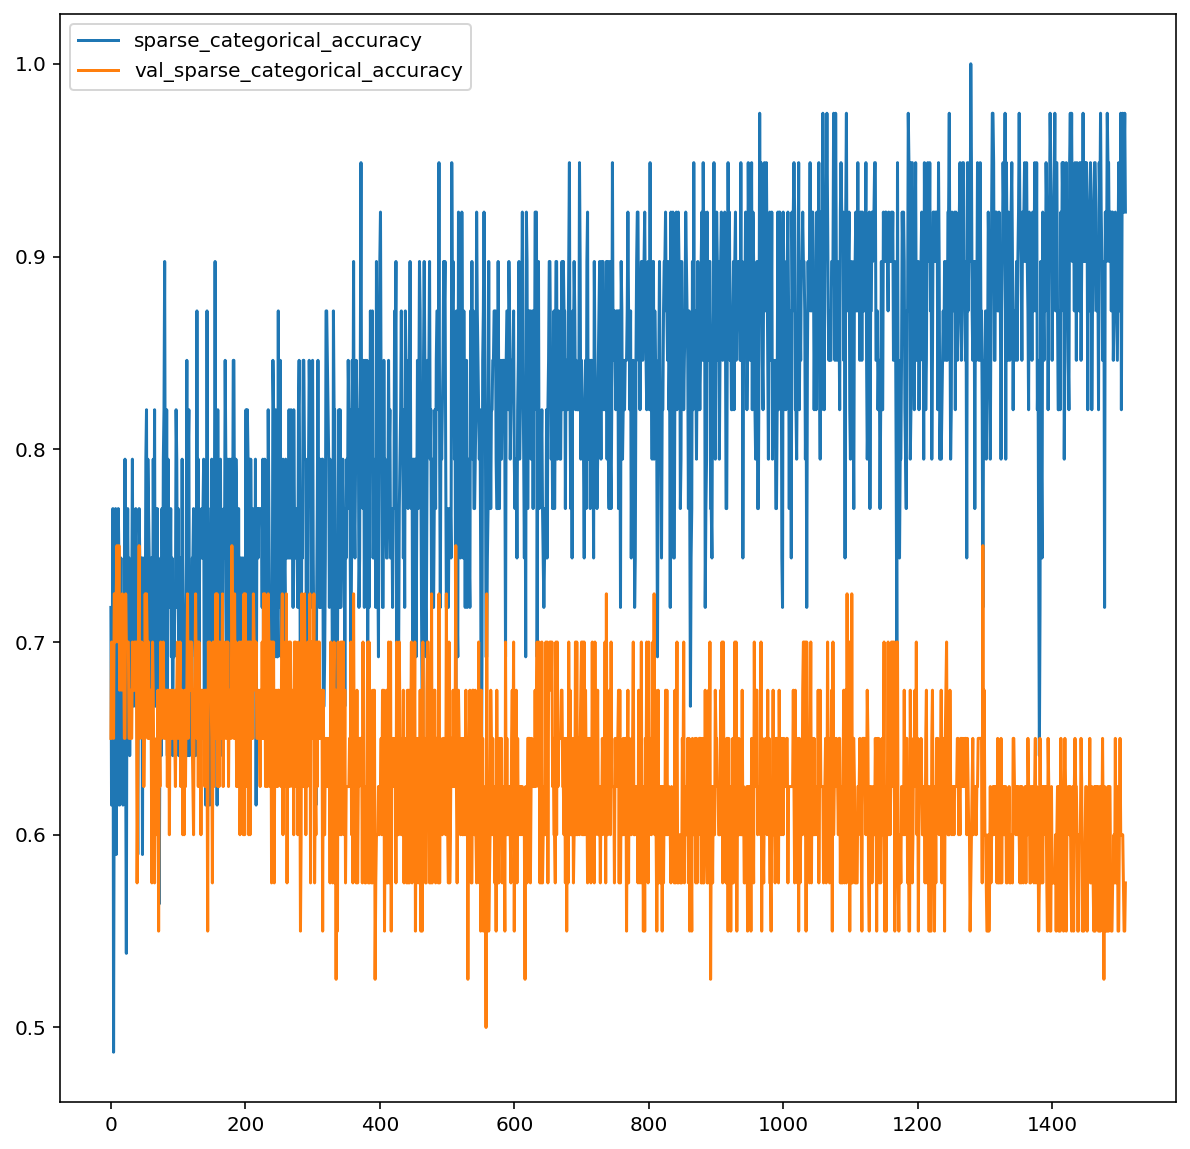

In [10]:
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    train_datagen = create_datagen(x_dataset[train_index])
    val_datagen = create_datagen(x_dataset[val_index])
    train_history = model.fit(train_datagen.flow(x_dataset[train_index], y_dataset[train_index], batch_size=256), batch_size=None, epochs=2250,
            #verbose=1, validation_data=val_datagen.flow(x_val, y_val, batch_size=128), callbacks=[callback])
          verbose=1, validation_data=(x_dataset[val_index], y_dataset[val_index]), callbacks=[early_stopping_callback])
    plot_learning_curve(train_history)
    model.save(f"{model_path}_skf={i}.hdf5", save_traces=True)



Accuracy:  0.775
Precision:  0.8461538461538461
Recall:  0.6111111111111112
F1 Score:  0.7096774193548387
Accuracy:  0.775
Precision:  0.9090909090909091
Recall:  0.5555555555555556
F1 Score:  0.6896551724137931
Accuracy:  0.75
Precision:  0.75
Recall:  0.6666666666666666
F1 Score:  0.7058823529411765


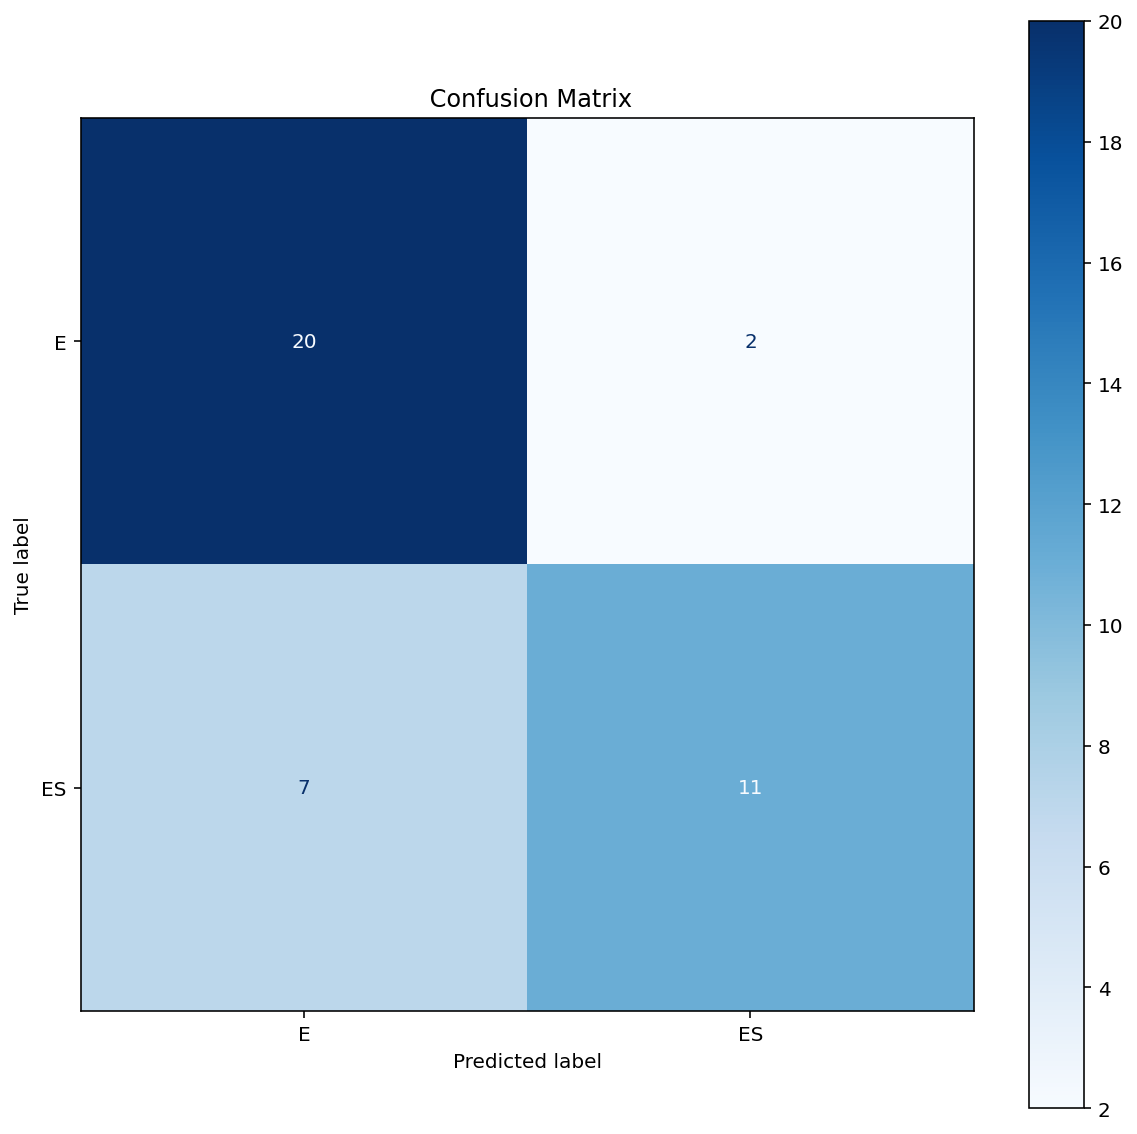

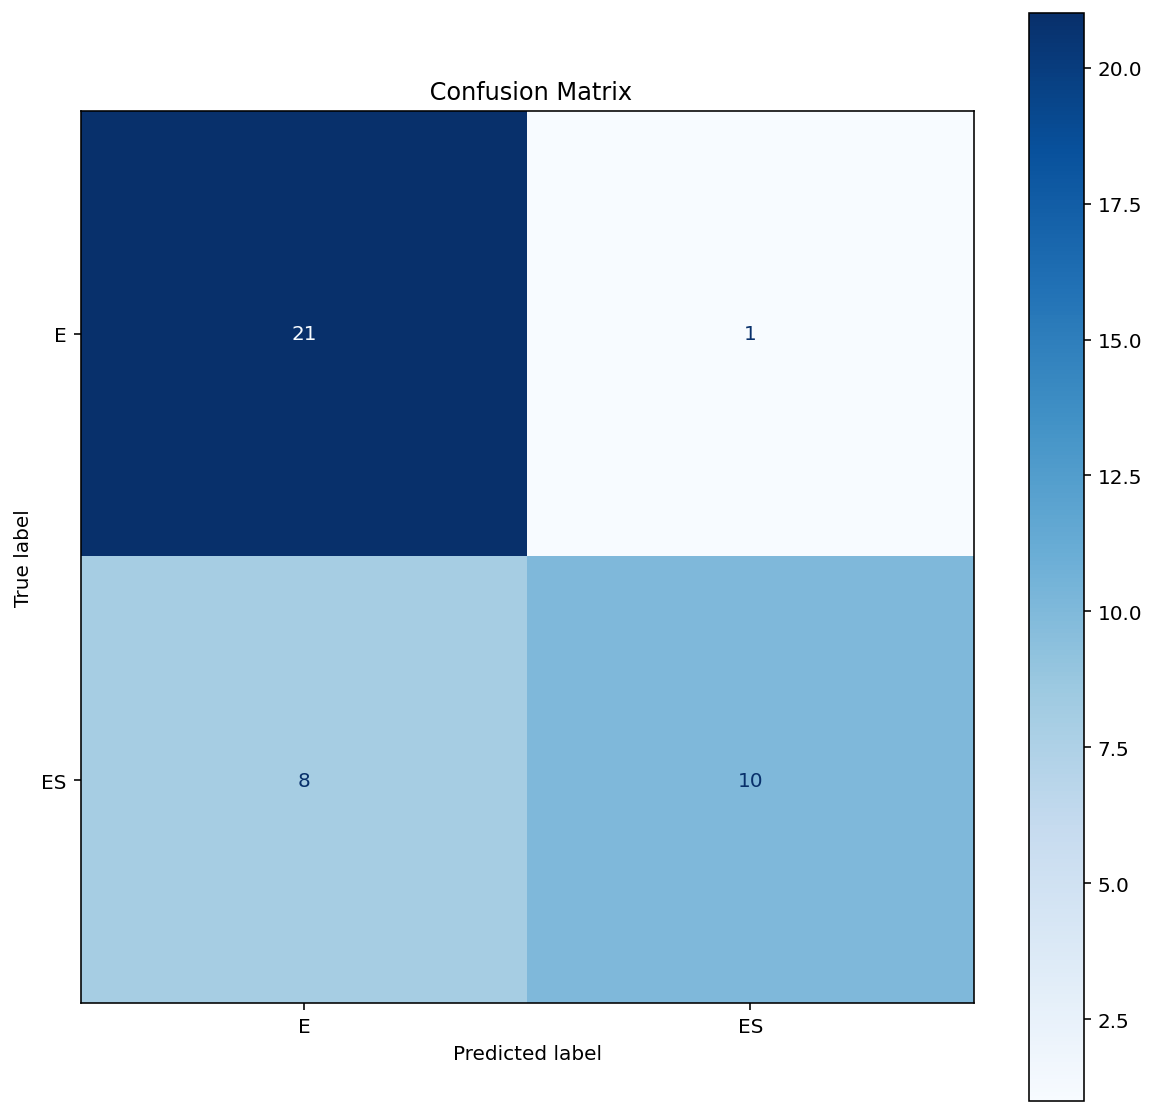

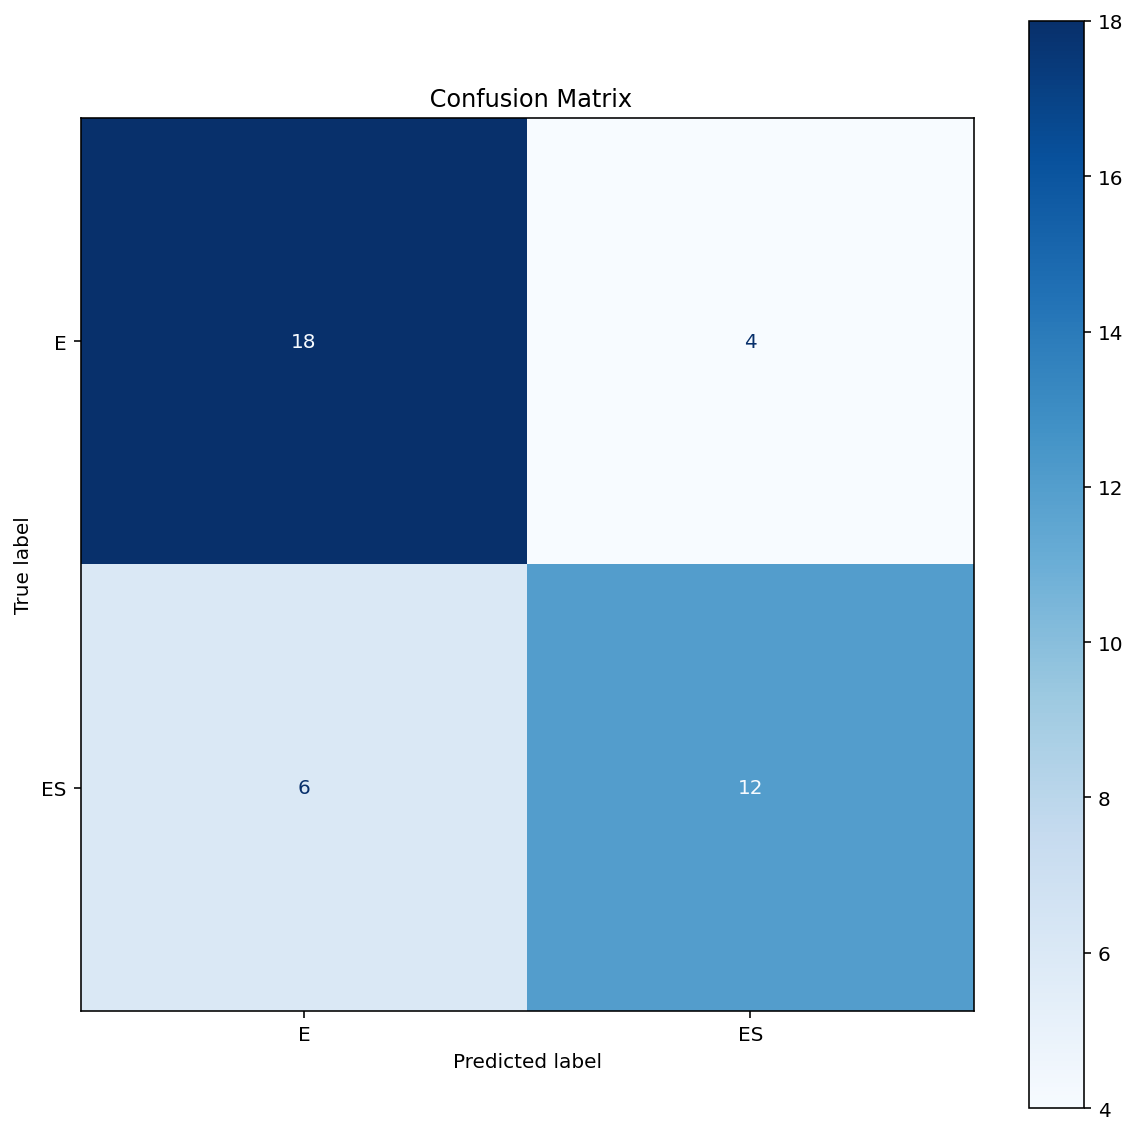

In [11]:
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    model = tf.keras.models.load_model(f"{model_path}_skf={i}.hdf5")
    plot_testing_results(model.predict(x_dataset[val_index]).argmax(axis=1), y_dataset[val_index])

In [12]:
#model.evaluate(val_datagen.flow(x_val, y_val, batch_size=128), return_dict=True)

{'Accuracy': 0.775,
 'ConfusionMatrix': array([[20,  2],
       [ 7, 11]], dtype=int64),
 'F1': 0.7096774193548387,
 'Precision': 0.8461538461538461,
 'Recall': 0.6111111111111112}
{'Accuracy': 0.775,
 'ConfusionMatrix': array([[21,  1],
       [ 8, 10]], dtype=int64),
 'F1': 0.6896551724137931,
 'Precision': 0.9090909090909091,
 'Recall': 0.5555555555555556}
{'Accuracy': 0.75,
 'ConfusionMatrix': array([[18,  4],
       [ 6, 12]], dtype=int64),
 'F1': 0.7058823529411765,
 'Precision': 0.75,
 'Recall': 0.6666666666666666}


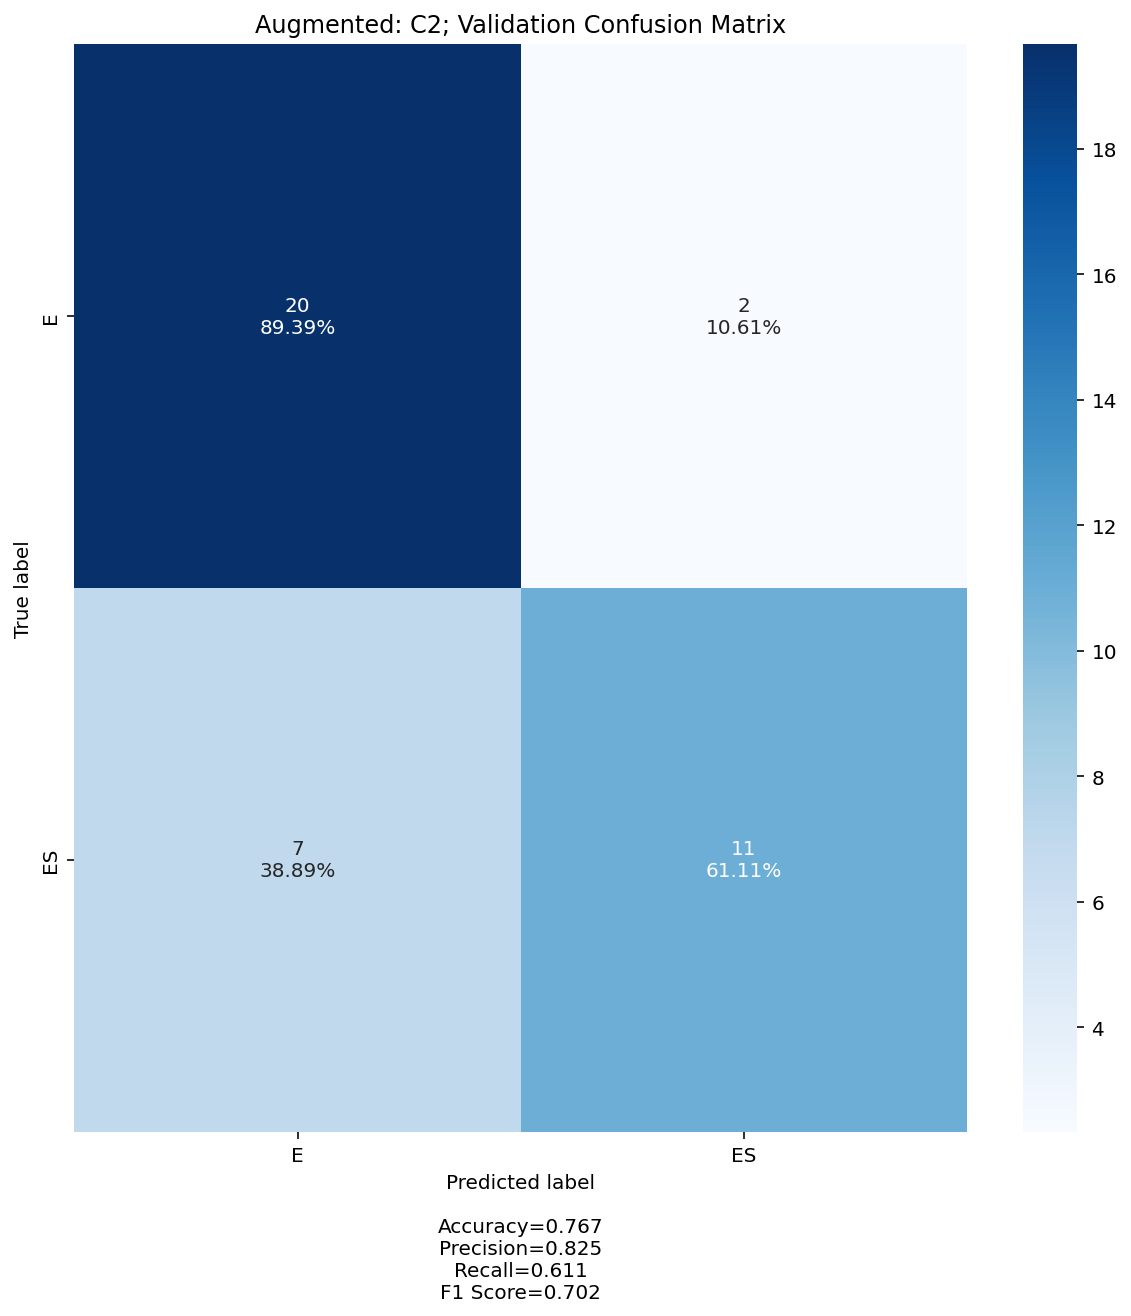

In [13]:
from pprint import pprint
training_results = []
validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    model = tf.keras.models.load_model(f"{model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_dataset[train_index], y_dataset[train_index], x_dataset[val_index], y_dataset[val_index], x_dataset, y_dataset)
    #training_results.append(get_results(tuned_model, x_dataset[train_index], y_dataset[train_index]))
    pprint(get_results(model, x_dataset[val_index], y_dataset[val_index]))
    validation_results.append(get_results(model, x_dataset[val_index], y_dataset[val_index]))
#average_and_plot_results(training_results, title="Augmented: C2; Training Confusion Matrix")
average_and_plot_results(validation_results, title="Augmented: C2; Validation Confusion Matrix")


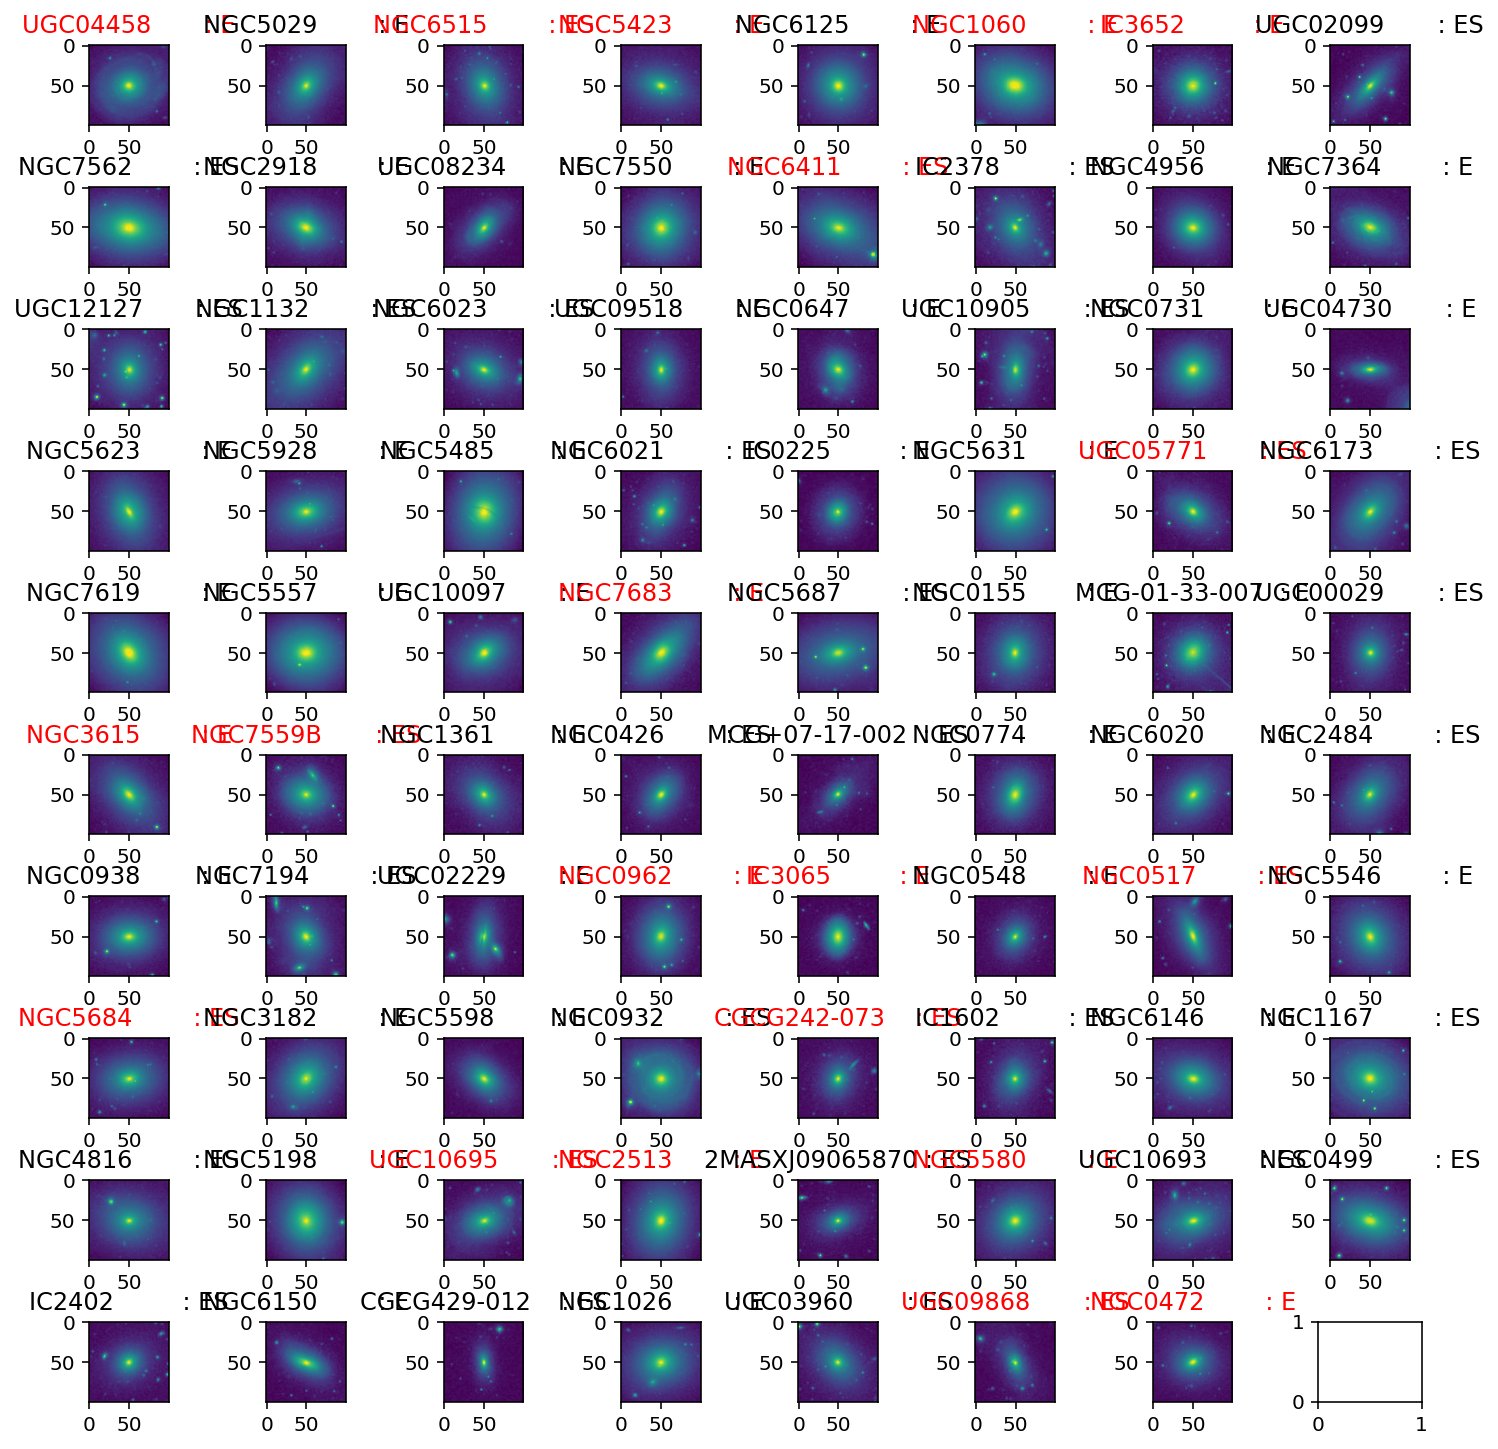

In [14]:
plot_classification_results(images=x_dataset, display_size=(10, 8), y_preds=model.predict(x_dataset).argmax(axis=1), y_trues=y_dataset,
                            y_labels=("E", "ES"),
                            galaxy_names=metadata["name"], random_sample=True)

In [15]:
#model.save(r"saved_models\califa_s_1.0_CNNo", overwrite=True)